In [1]:
import os
import torch
import requests
import warnings
import numpy as np
import pandas as pd
from urllib import parse
from datetime import datetime
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_forecasting.data import GroupNormalizer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting.metrics import SMAPE, QuantileLoss
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

warnings.filterwarnings("ignore")


In [3]:
os.chdir("..")

data = pd.read_csv("data/All_music.csv")
data.sort_values(by=["timestamp"],inplace=True) # for my sanity
data["timestamp"] = pd.to_datetime(data["timestamp"]) # needed to create time_index

#group by month
# data["time_idx"] = data["timestamp"].dt.year * 12 + data["timestamp"].dt.month
# data["time_idx"] -= data["time_idx"].min()

data["month"] = data["timestamp"].dt.month.astype(str).astype("category")
data["log_views"] = np.log(data["views"] + 1e-8)


data["time_idx"] = data.index.astype(int)
#data["timestamp"] = data["timestamp"].astype(str).astype('category')
# (data.groupby("project")["time_idx"].diff() == 1).value_counts()


# # add time index
# data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
# data["time_idx"] -= data["time_idx"].min()
data.drop(["project","granularity","access","agent"],inplace=True,axis=1)
data["article"] = data["article"].astype(str).astype("category")

# Delete wrong data
data = data[data["article"] != "Paper_Doll"]
data = data[data["article"] != "Y.M.C.A"]
data = data[data["article"] != "Bei_Mir_Bist_Du_Schön"]

#new Features
data["dayofweek"] = data["timestamp"].dt.dayofweek.astype(str).astype("category")
data["log_views"] = np.log(data["views"] + 1e-8)
data["month"] = data["timestamp"].dt.month.astype(str).astype("category")
data["year"] = data["timestamp"].dt.year.astype(str).astype("category")
data["avg_by_song"] = data.groupby(["month","year","article"],observed=True)["views"].transform("mean")

(data.groupby("article")["time_idx"].diff() == 1).value_counts()

c:\Users\Mohammad Sakhnini\git\PageView_Prediction\Transformer


FileNotFoundError: [Errno 2] No such file or directory: 'data/All_music.csv'

In [8]:
# checking for correct datatype
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146378 entries, 0 to 150690
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   146378 non-null  int64         
 1   article      146378 non-null  category      
 2   timestamp    146378 non-null  datetime64[ns]
 3   views        146378 non-null  int64         
 4   month        146378 non-null  category      
 5   log_views    146378 non-null  float64       
 6   time_idx     146378 non-null  int64         
 7   dayofweek    146378 non-null  category      
 8   year         146378 non-null  category      
 9   avg_by_song  146378 non-null  float64       
dtypes: category(4), datetime64[ns](1), float64(2), int64(3)
memory usage: 8.4 MB


In [3]:
max_encoder_length = 30   #
max_prediction_length = 14  # predict last 14 days
test_cutoff = data.time_idx.max() - max_prediction_length
training_cutoff = test_cutoff - max_prediction_length

HIDDEN_SIZE = 6
HIDDEN_CONTINOUS_SIZE = HIDDEN_SIZE // 2
#create test set.
data_test = data[lambda x:  test_cutoff < x.time_idx]

# create train+val part
data_seen = data[lambda x:  x.time_idx <= test_cutoff]


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="views",
    group_ids=["article"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    target_normalizer=GroupNormalizer(groups=["article"]),
    time_varying_known_categoricals=["dayofweek", "month", "year"],
    time_varying_known_reals=["log_views"],
    static_categoricals=["article"],
    time_varying_unknown_reals=["avg_by_song", "log_views"],
    #allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True)


# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data_seen, predict=True, stop_randomization=True)


# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0)


# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()




614.5263671875

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 4.6k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at c:\Users\Mohammad Sakhnini\git\PageView_Prediction\.lr_find_4c0ddec5-2947-4789-a075-1594be1ae868.ckpt


suggested learning rate: 0.12882495516931336


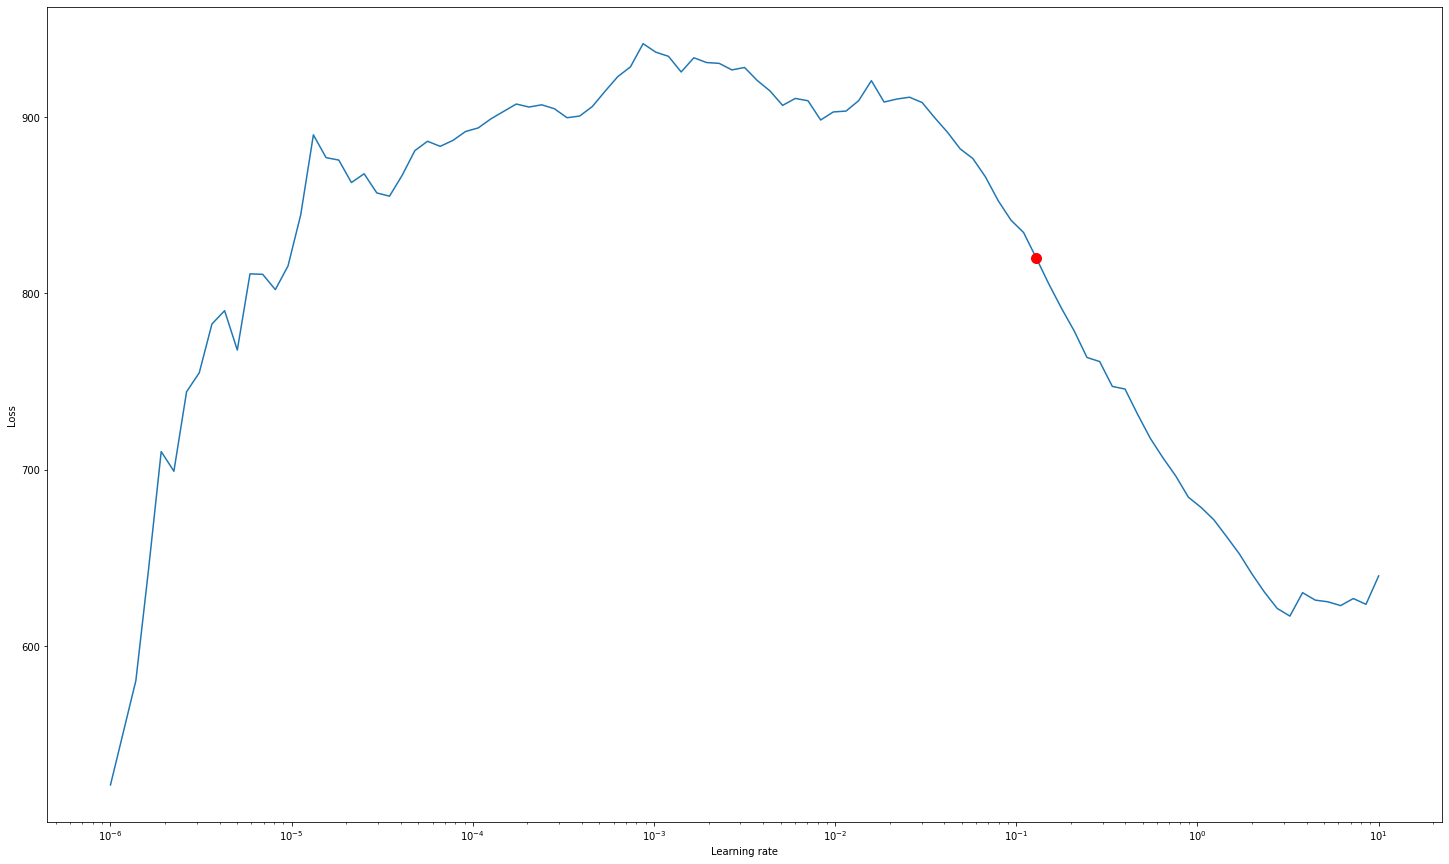

In [20]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=HIDDEN_SIZE,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=HIDDEN_CONTINOUS_SIZE,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [25]:
l_r = 0.15135612484362077
path = "tft_model_hidden6_oneMonth.pth"


early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    gradient_clip_val=0.1,
    #limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    limit_train_batches=1.0, #if set to 1.0 gather all training data, default.
    callbacks=[lr_logger, early_stop_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=l_r,
    hidden_size=HIDDEN_SIZE,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=HIDDEN_CONTINOUS_SIZE,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)


# if os.path.exists(path):
#     tft.load_state_dict(torch.load(path))
#     tft.eval()
    
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

#torch.save(tft.state_dict(),path)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 537   
3  | prescalers                         | ModuleDict                      | 36    
4  | static_variable_selection          | VariableSelectionNetwork        | 486   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 726   
6  | decoder_variable_selection      

Number of parameters in network: 4.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [6]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-10-31 10:07:34,152] A new study created in memory with name: no-name-ca15e226-7039-44a9-9b13-6aeb8c17958d
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-10-31 10:11:22,995] Trial 0 finished with value: 142.14273071289062 and parameters: {'gradient_clip_val': 0.01287828558795008, 'hidden_size': 30, 'dropout': 0.14827100921459113, 'hidden_continuous_size': 20, 'attention_head_size': 3, 'learning_rate': 0.003109996132336887}. Best is trial 0 with value: 142.14273071289062.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-10-31 10:14:56,026] Trial 1 finished with value: 302.52462768554

{'gradient_clip_val': 0.9195473718970013, 'hidden_size': 38, 'dropout': 0.16527230923795627, 'hidden_continuous_size': 32, 'attention_head_size': 3, 'learning_rate': 0.05883973479371829}


In [23]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
path = "hidden6_oneMonth\epoch=49.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(path)

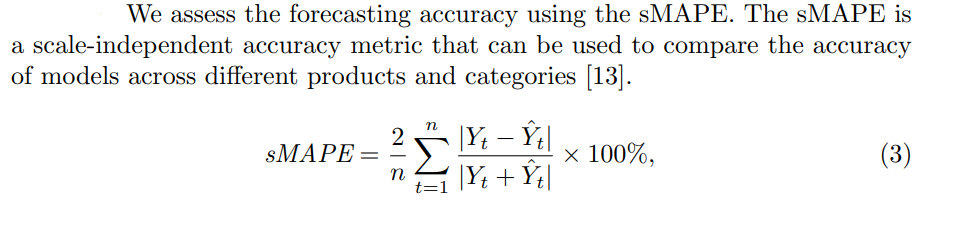

In [6]:
import numpy as np

def smape(target, forecast):
  if type(target) == pd.core.frame.DataFrame:
    target = target.values

  denominator = np.abs(target) + np.abs(forecast)
  flag = denominator == 0.

  smape = 2 * np.mean(
      (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
  )
  return smape

<class 'torch.Tensor'>


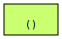

In [21]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean().item()

In [19]:
# calculate sMAPE on validation set.
target = actuals.numpy()
forecast = predictions.numpy()
smape(target, forecast)

0.11042709048281232

In [26]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

tensor([[5.3346e+02, 4.6970e+02, 4.5599e+02, 4.6304e+02, 4.6214e+02, 4.9522e+02,
         5.8399e+02, 5.3507e+02, 6.4179e+02, 5.5975e+02, 5.8256e+02, 5.7821e+02,
         6.8747e+02, 7.3430e+02],
        [6.0284e+02, 6.1676e+02, 6.0684e+02, 6.2014e+02, 6.7335e+02, 6.8083e+02,
         6.6200e+02, 6.7942e+02, 6.8160e+02, 7.0888e+02, 6.9089e+02, 7.2251e+02,
         6.6650e+02, 7.1562e+02],
        [7.8983e+02, 6.7760e+02, 6.8973e+02, 6.1749e+02, 7.3348e+02, 7.4701e+02,
         8.2626e+02, 9.1961e+02, 9.1968e+02, 7.4492e+02, 7.8067e+02, 8.8930e+02,
         1.3209e+03, 1.0165e+03],
        [5.2913e+02, 4.7942e+02, 5.2103e+02, 7.4039e+02, 6.4931e+02, 5.1454e+02,
         4.4924e+02, 3.2094e+02, 3.7400e+02, 3.3092e+02, 2.2047e+02, 2.9487e+02,
         2.9080e+02, 2.1666e+02],
        [1.2130e+04, 1.2337e+04, 1.4221e+04, 1.5599e+04, 1.8422e+04, 2.8649e+04,
         3.5629e+04, 1.3913e+04, 7.7393e+03, 5.8763e+03, 4.9243e+03, 3.8848e+03,
         3.8761e+03, 3.6772e+03],
        [6.4356e+02,

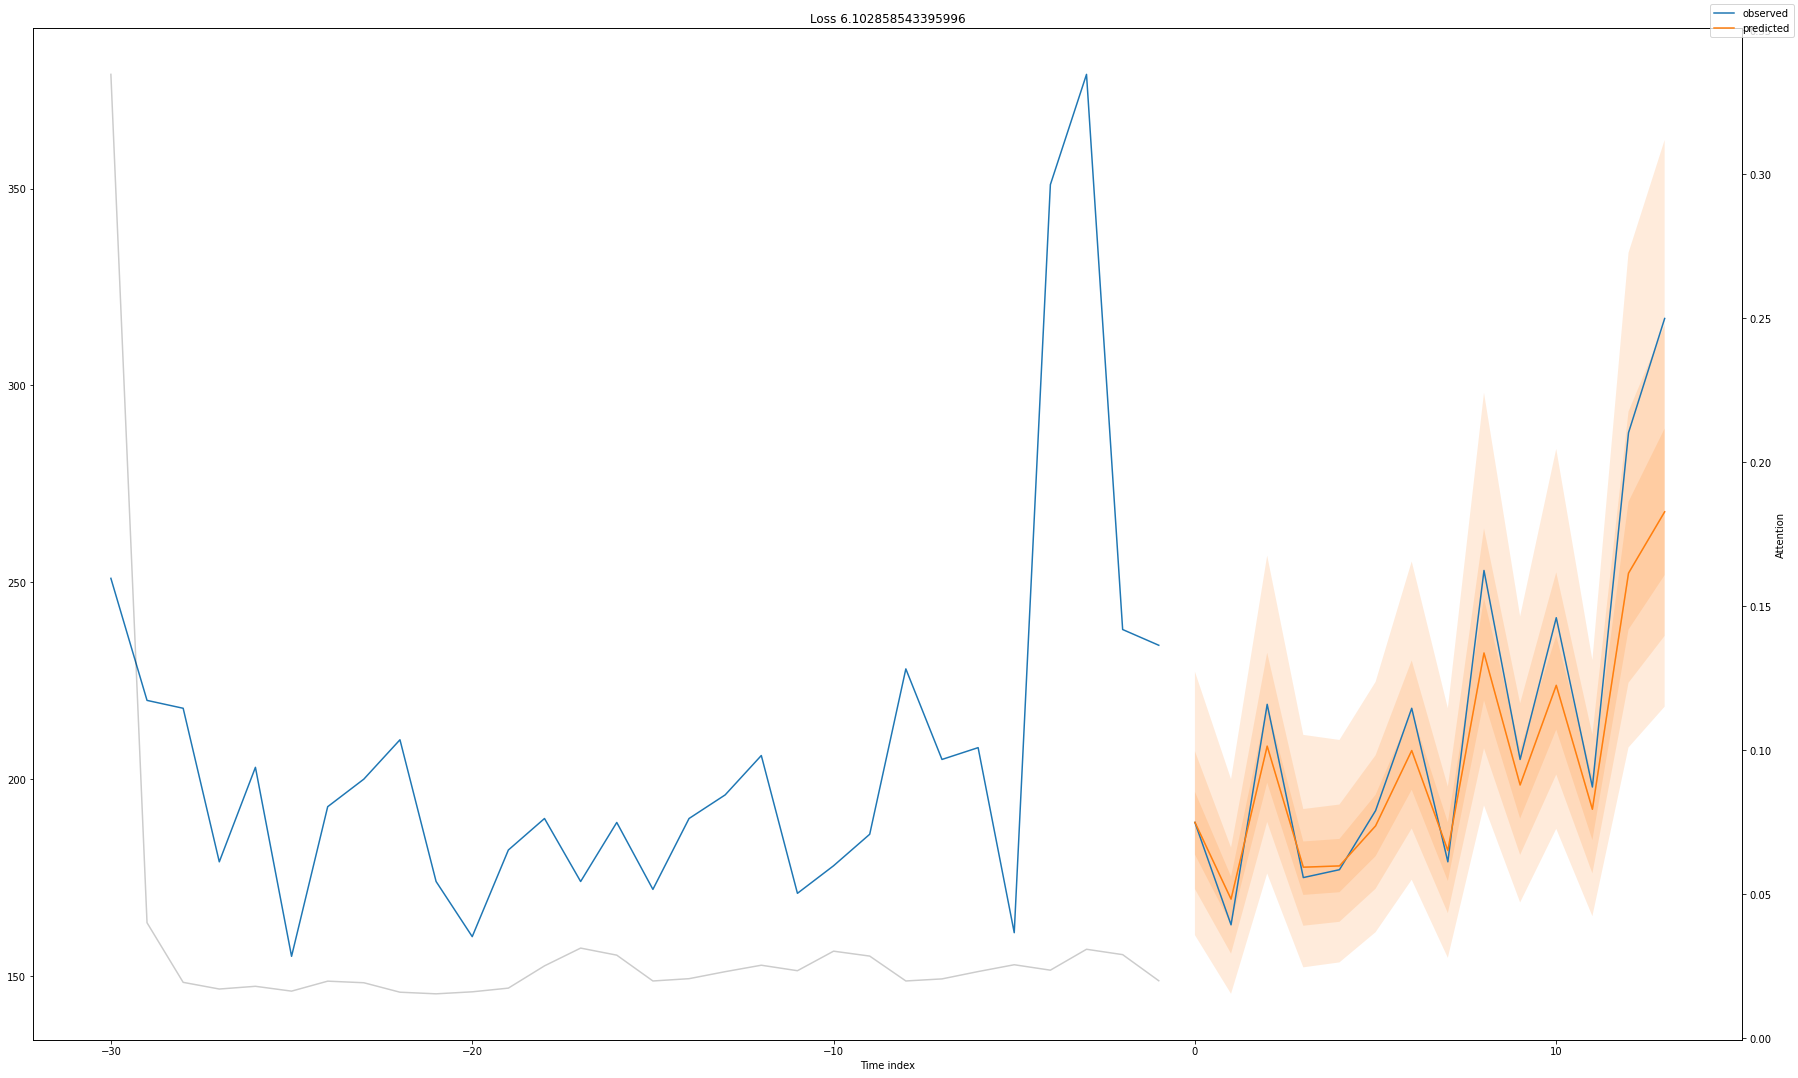

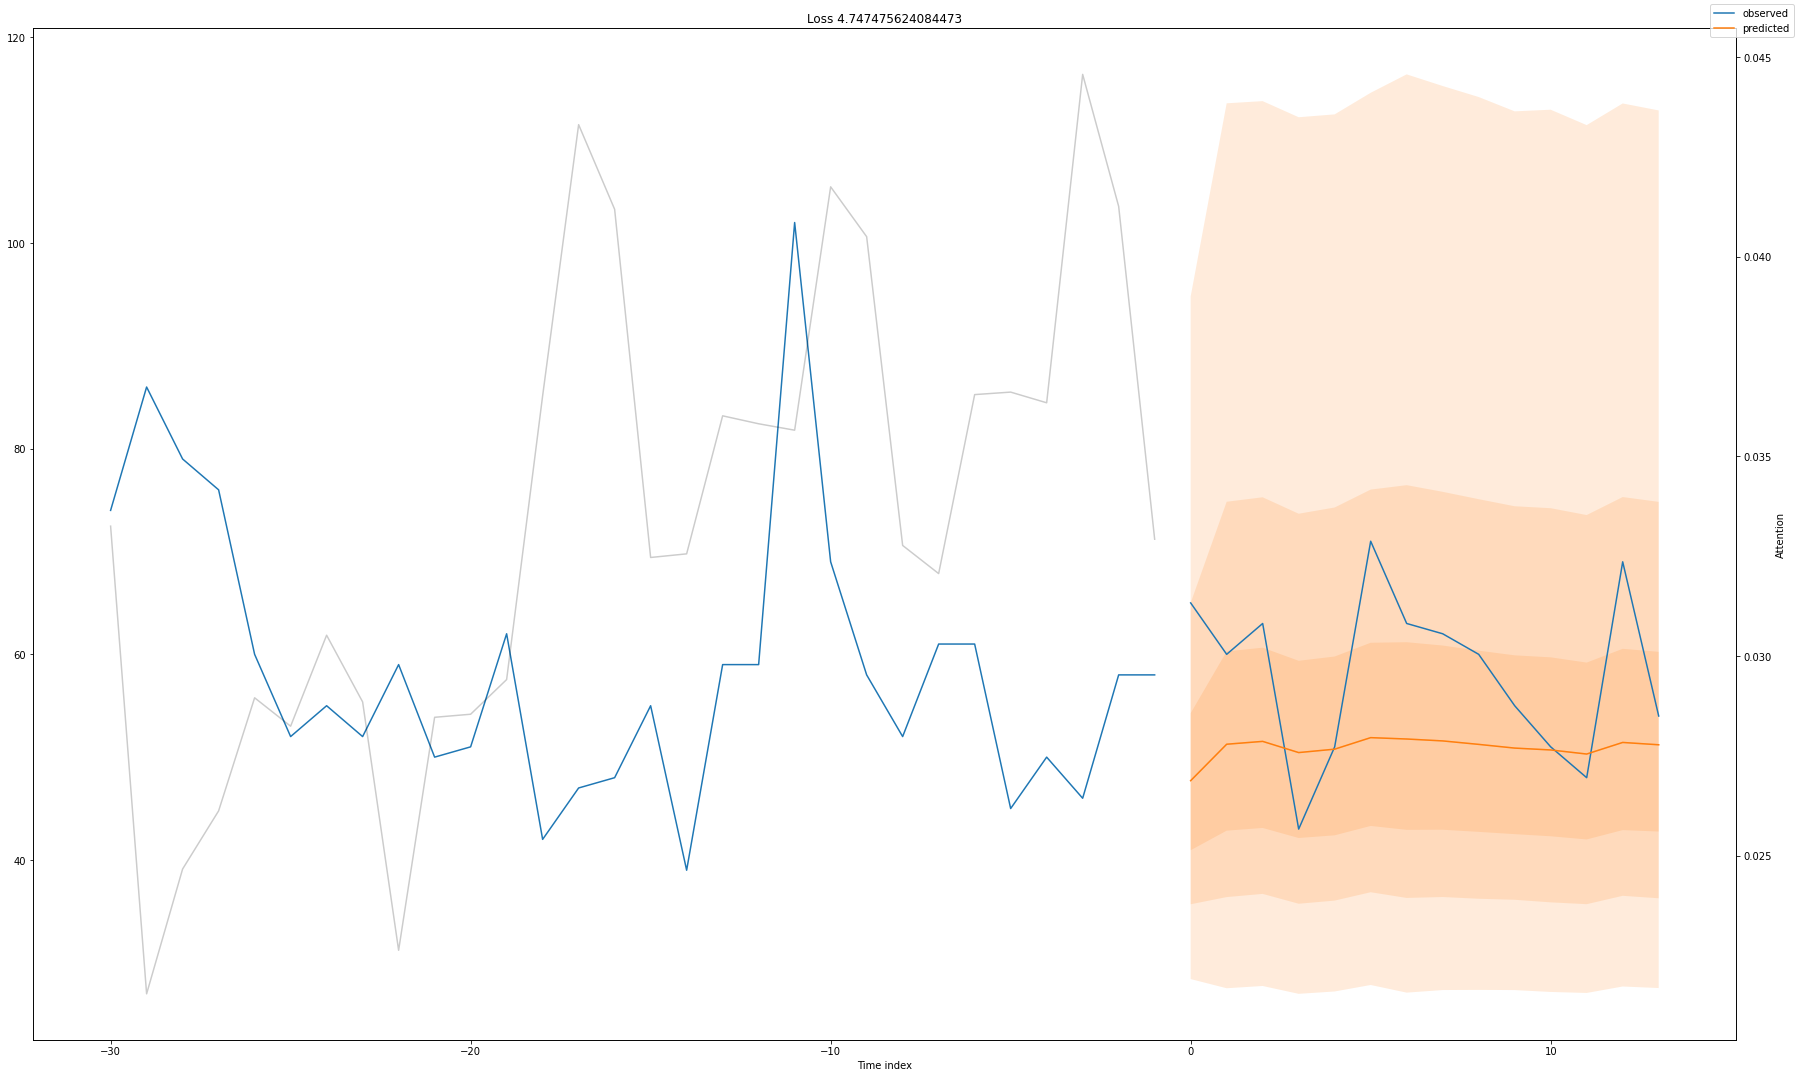

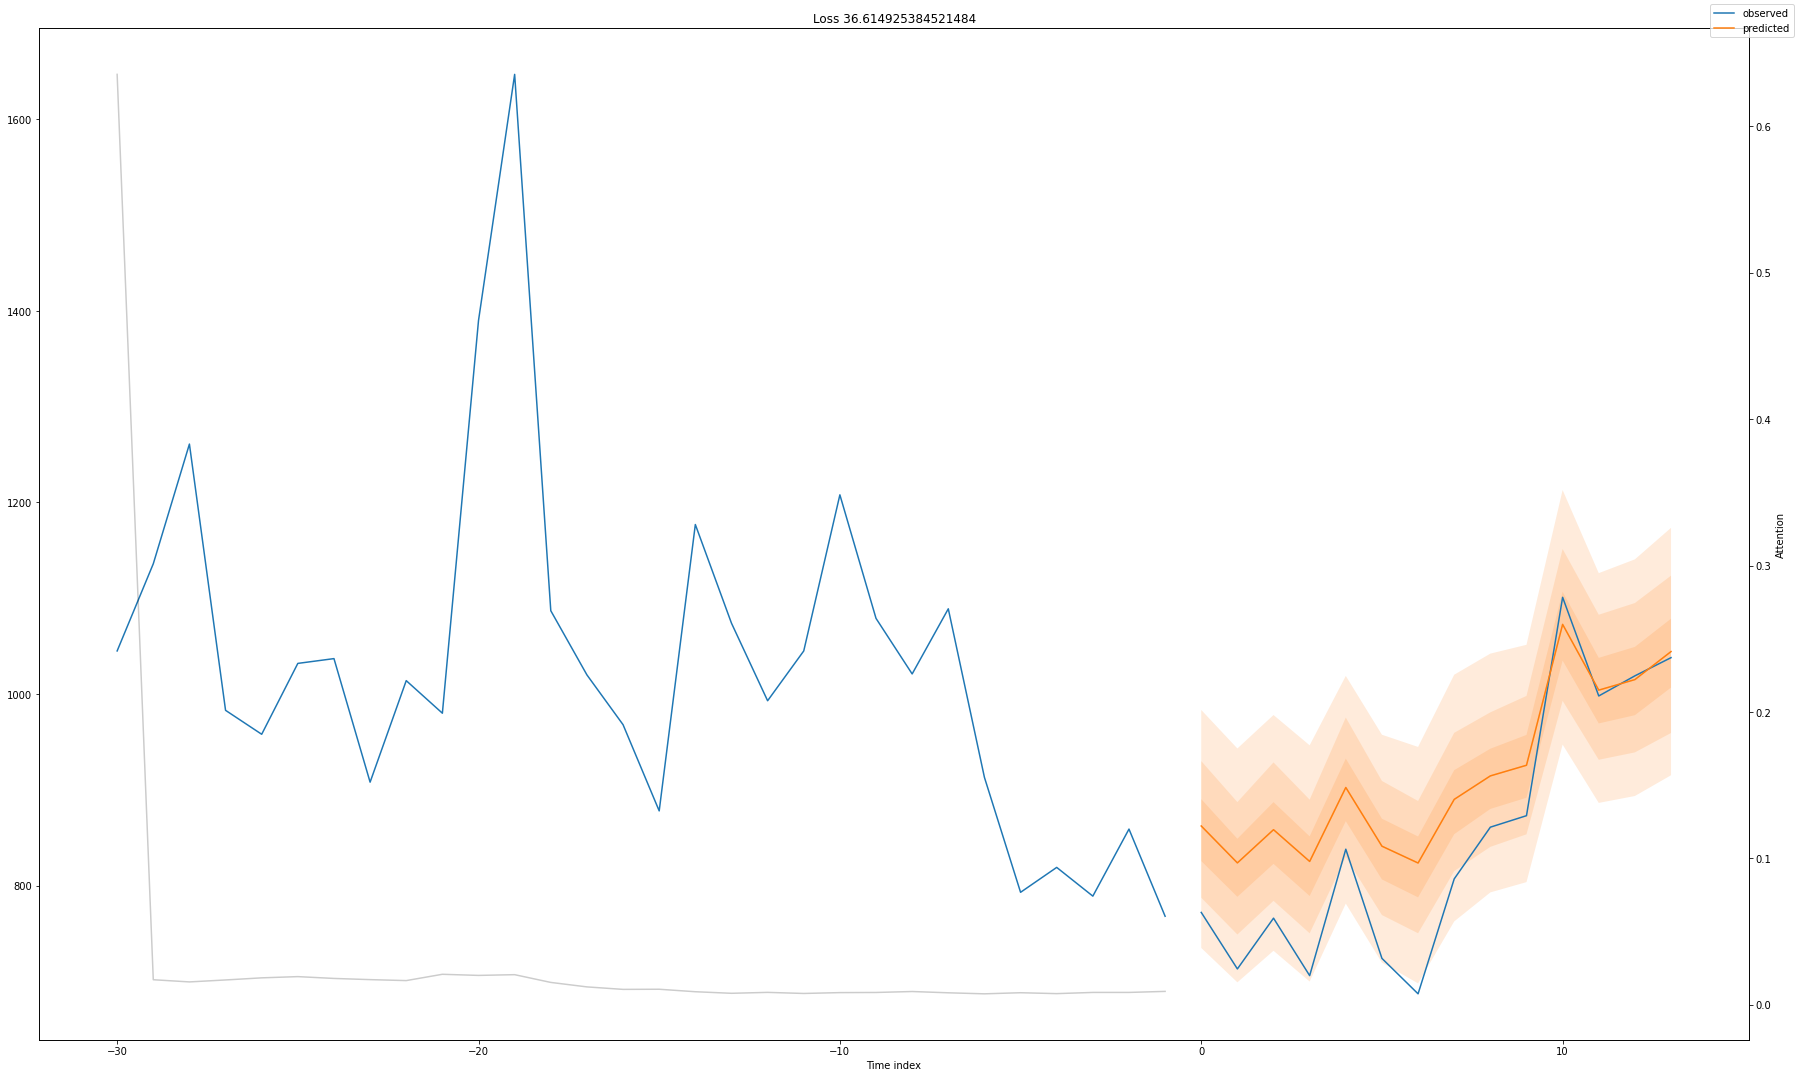

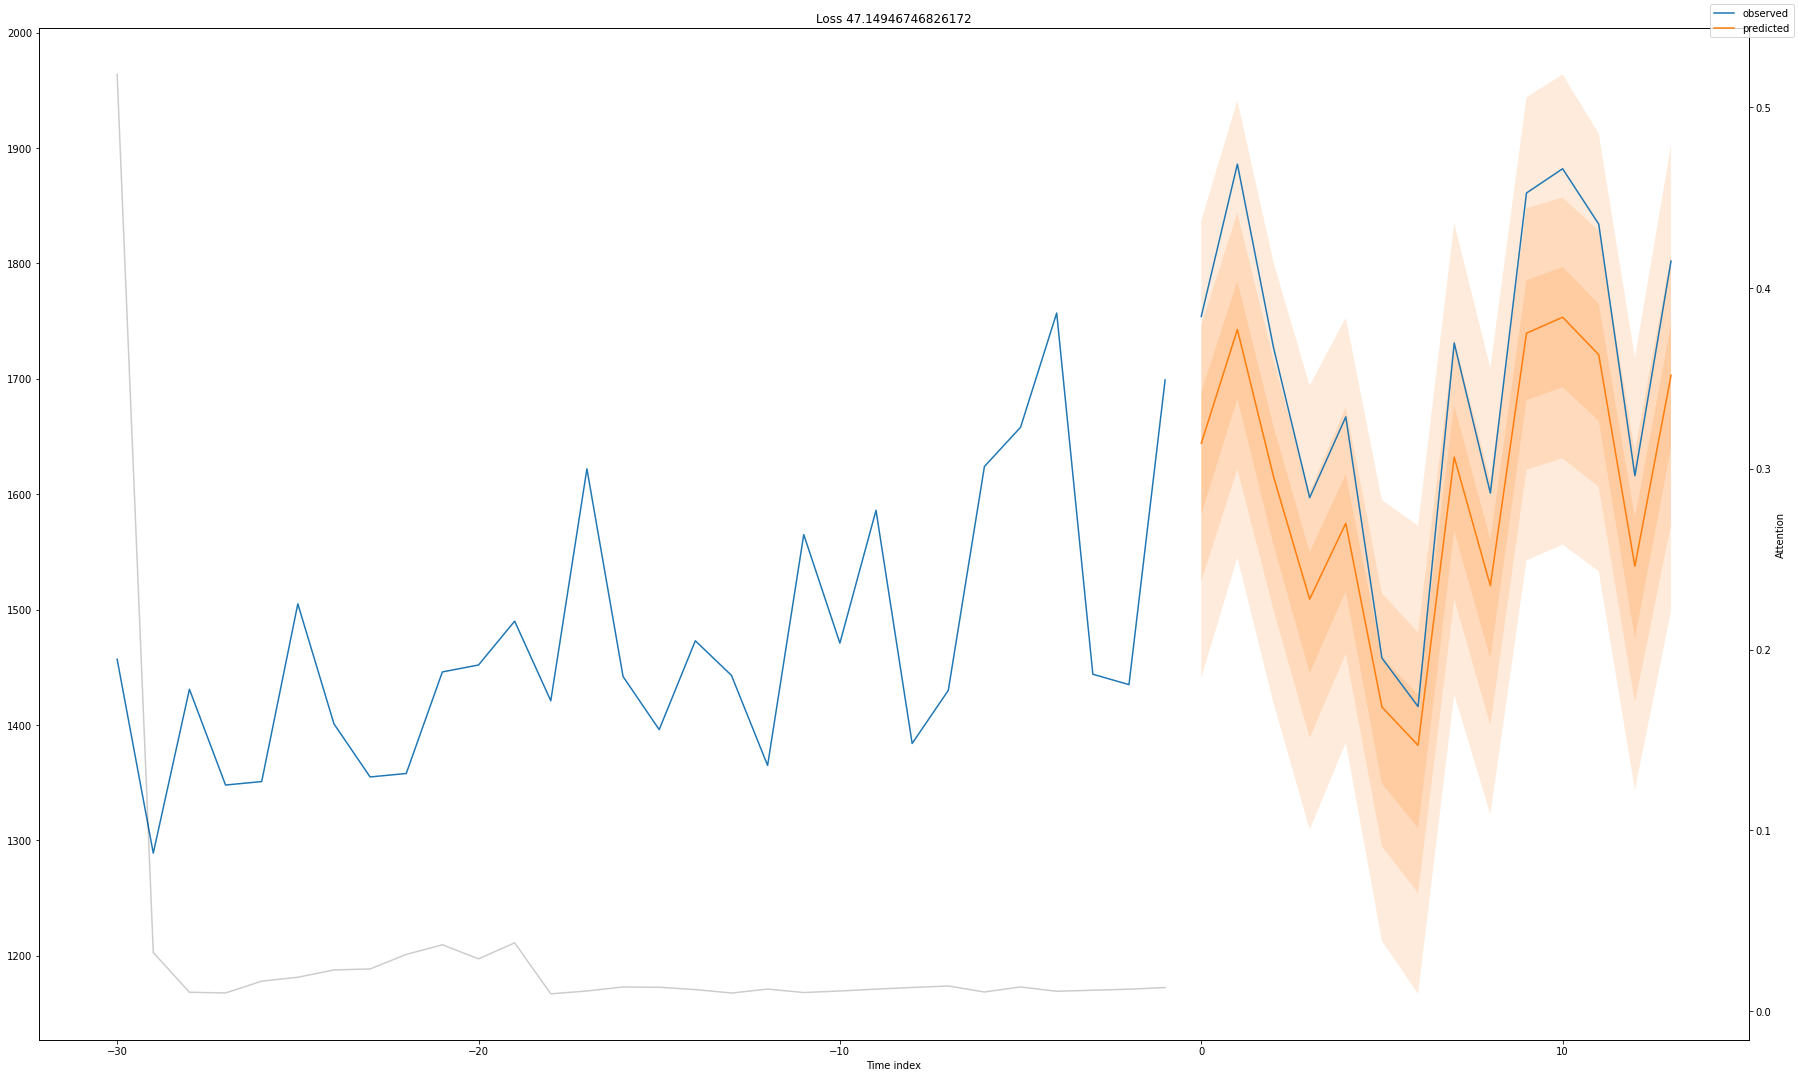

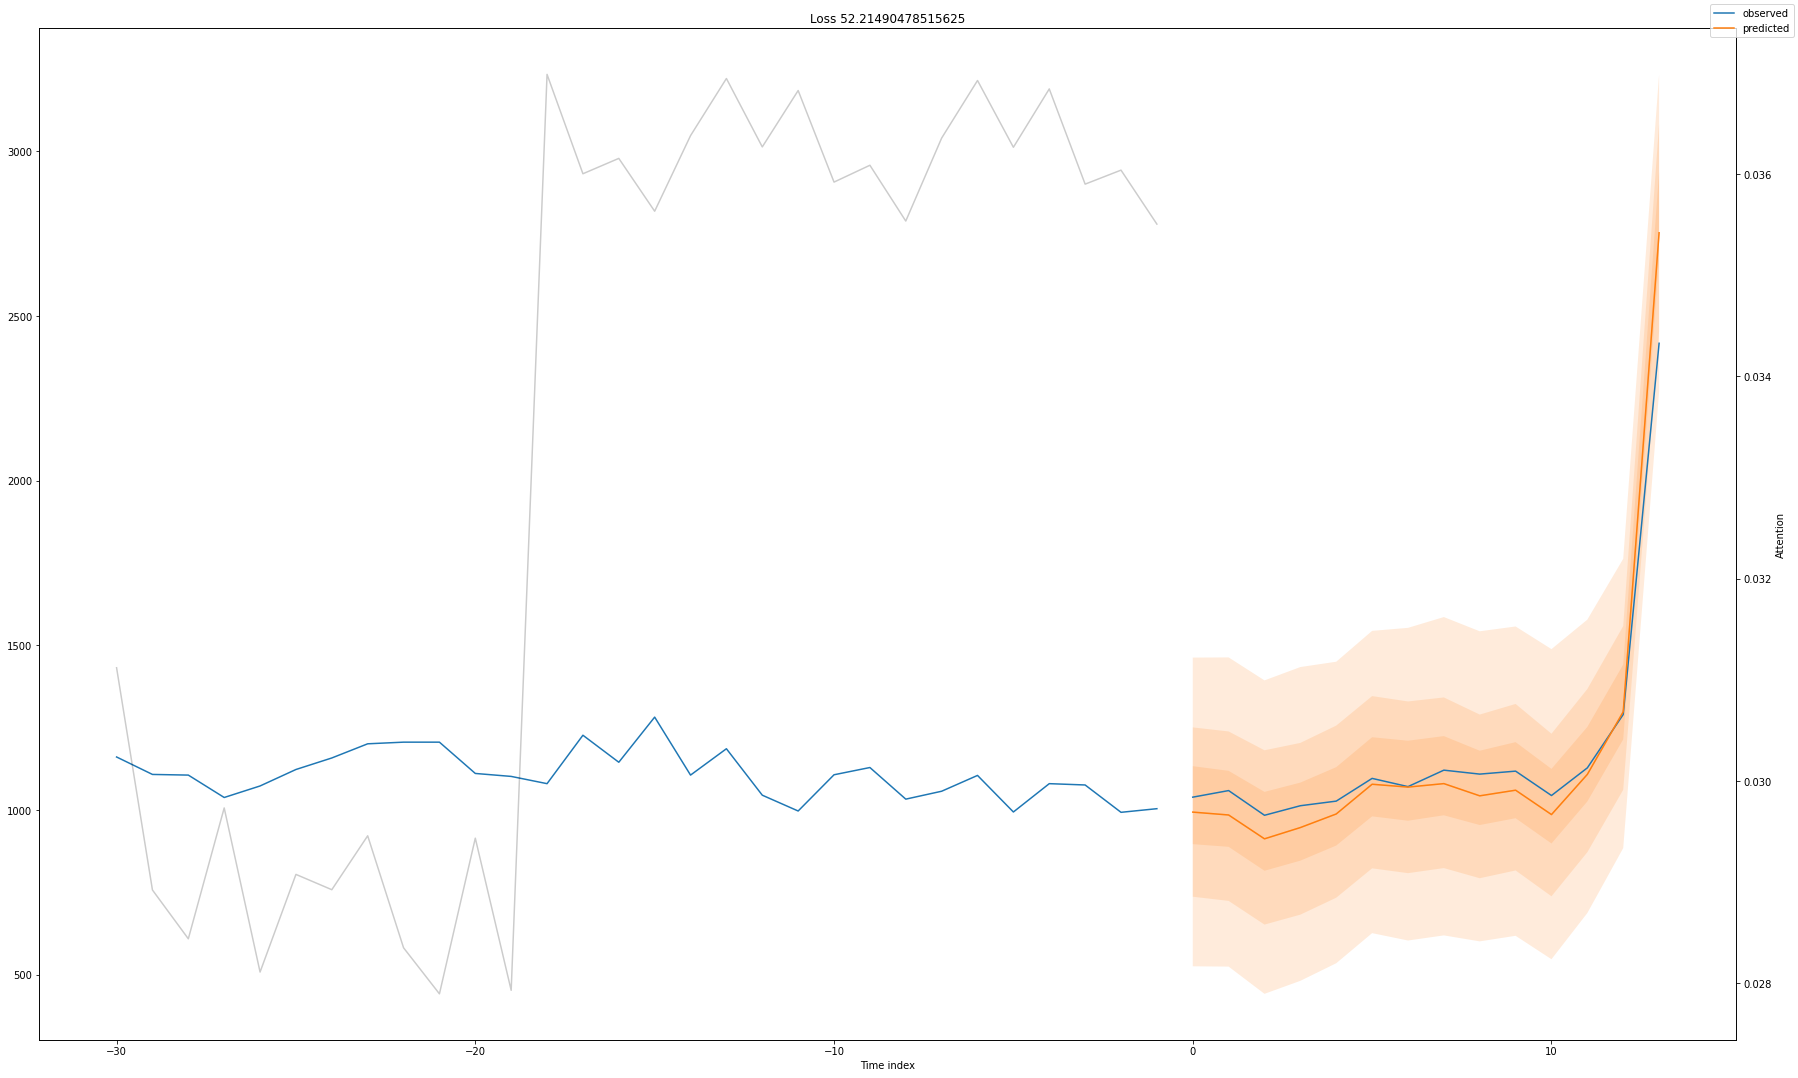

In [20]:
# calculate metric by which to display
from pylab import rcParams
rcParams['figure.figsize'] = 25, 15

predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
for idx in np.random.randint(0,50,size=5):  # plot 20 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

{'attention': <Figure size 1800x1080 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x180 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

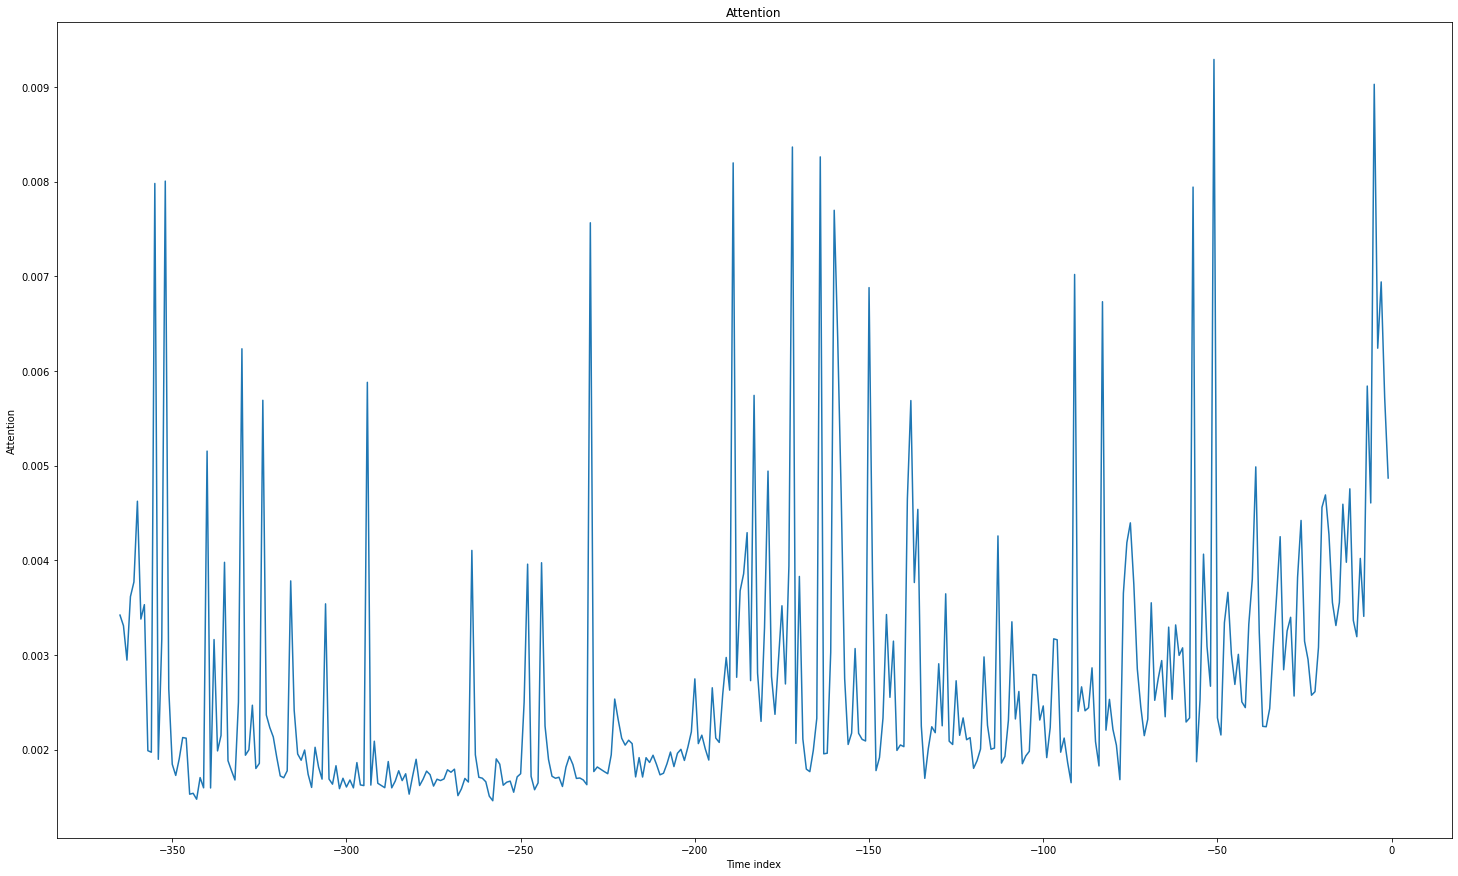

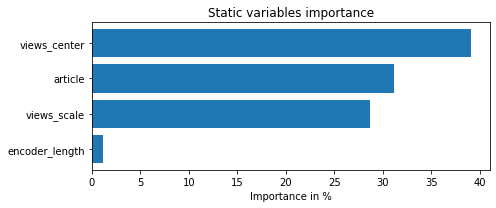

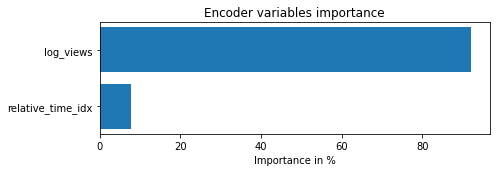

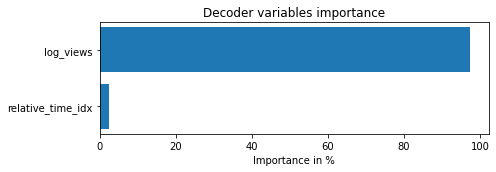

In [16]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'views_center': <Figure size 720x360 with 2 Axes>,
 'views_scale': <Figure size 720x360 with 2 Axes>,
 'log_views': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'article': <Figure size 720x360 with 2 Axes>}

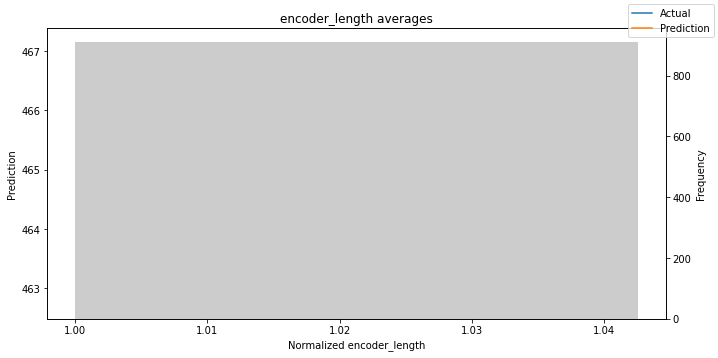

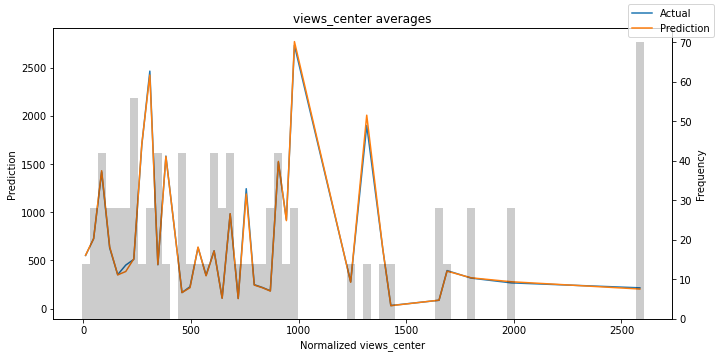

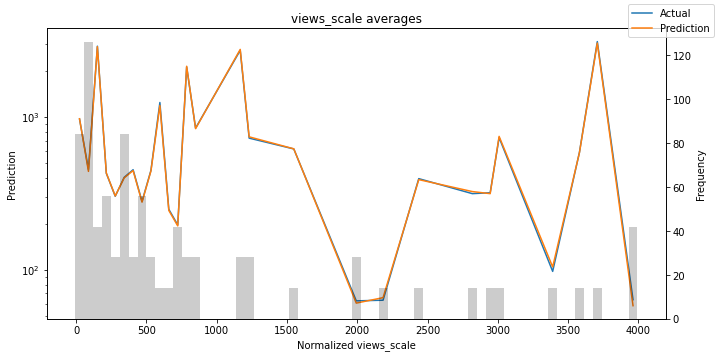

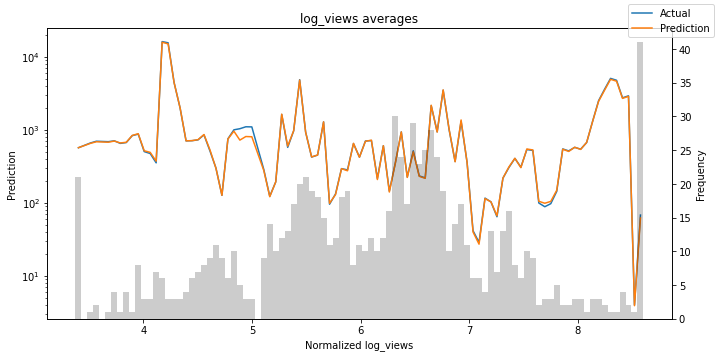

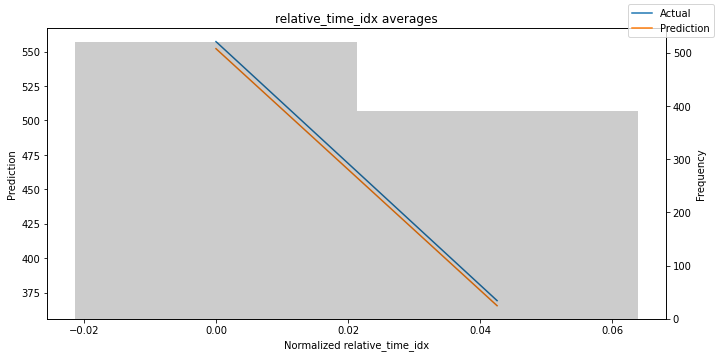

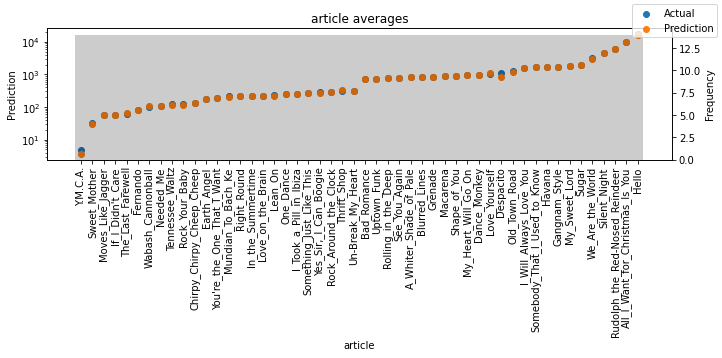

In [17]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

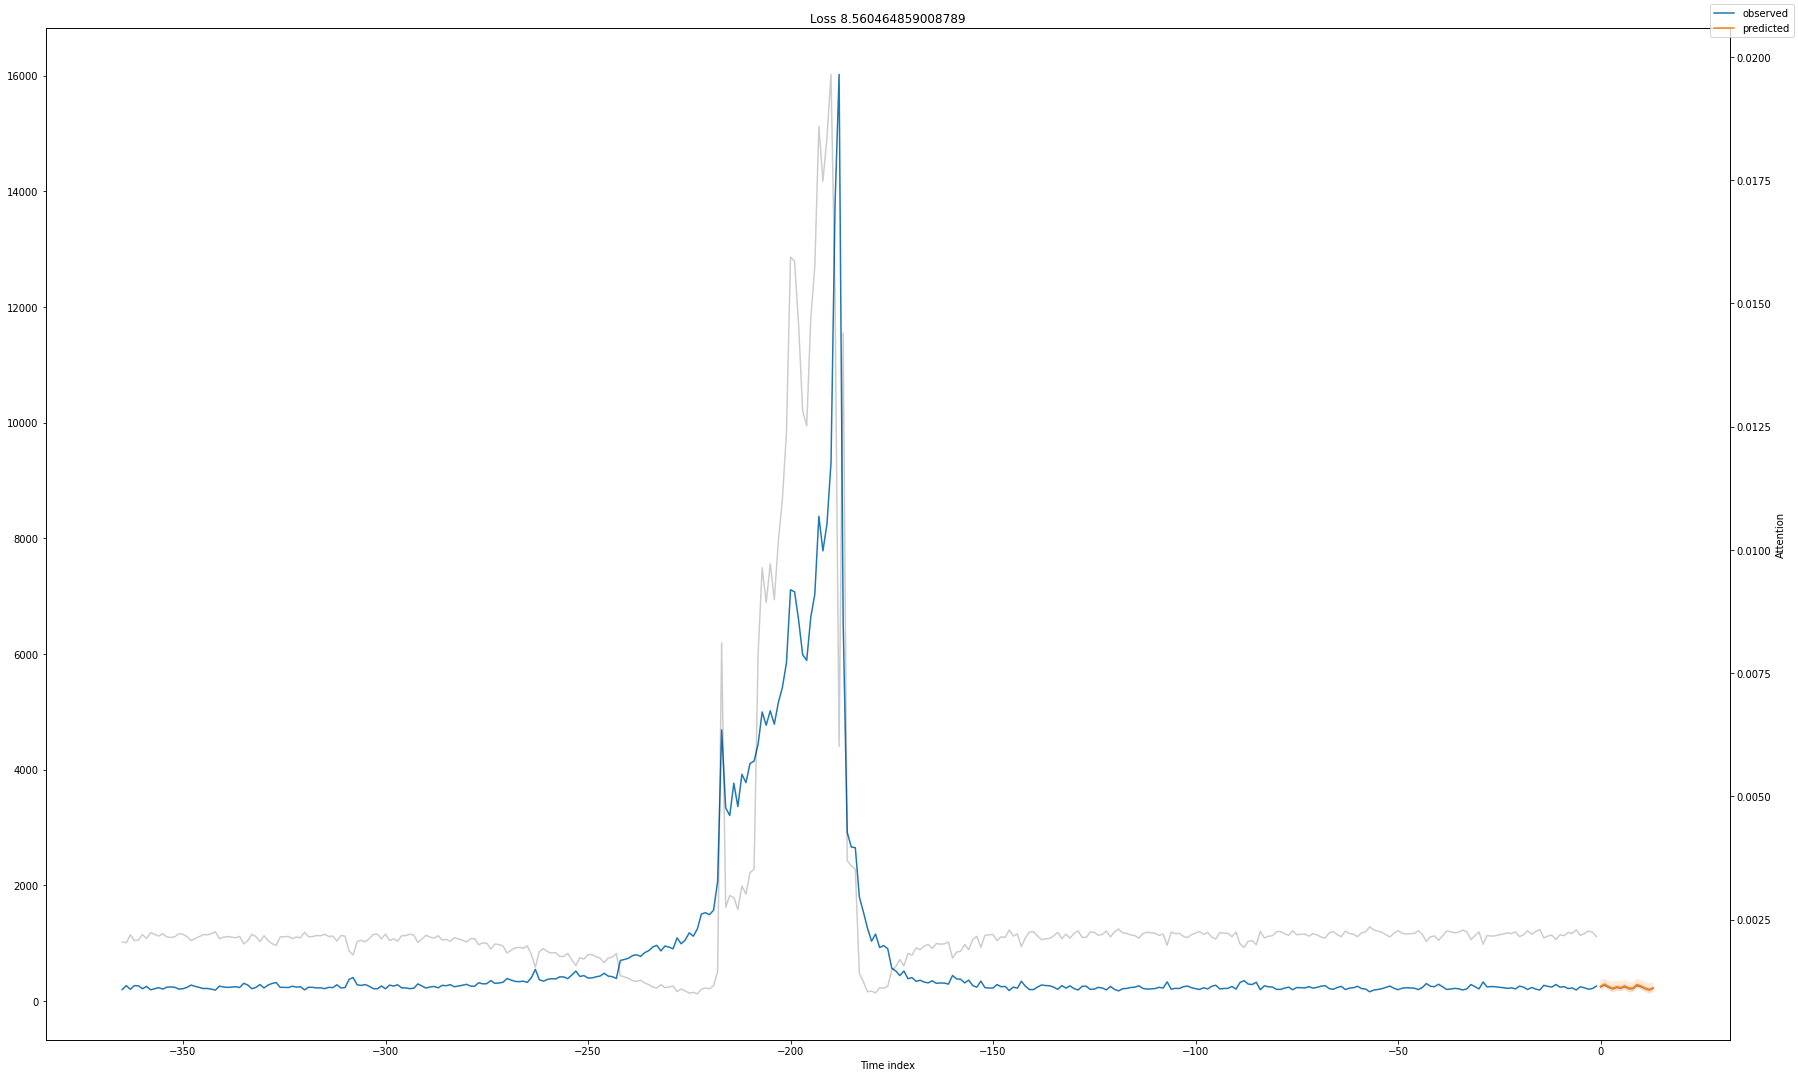

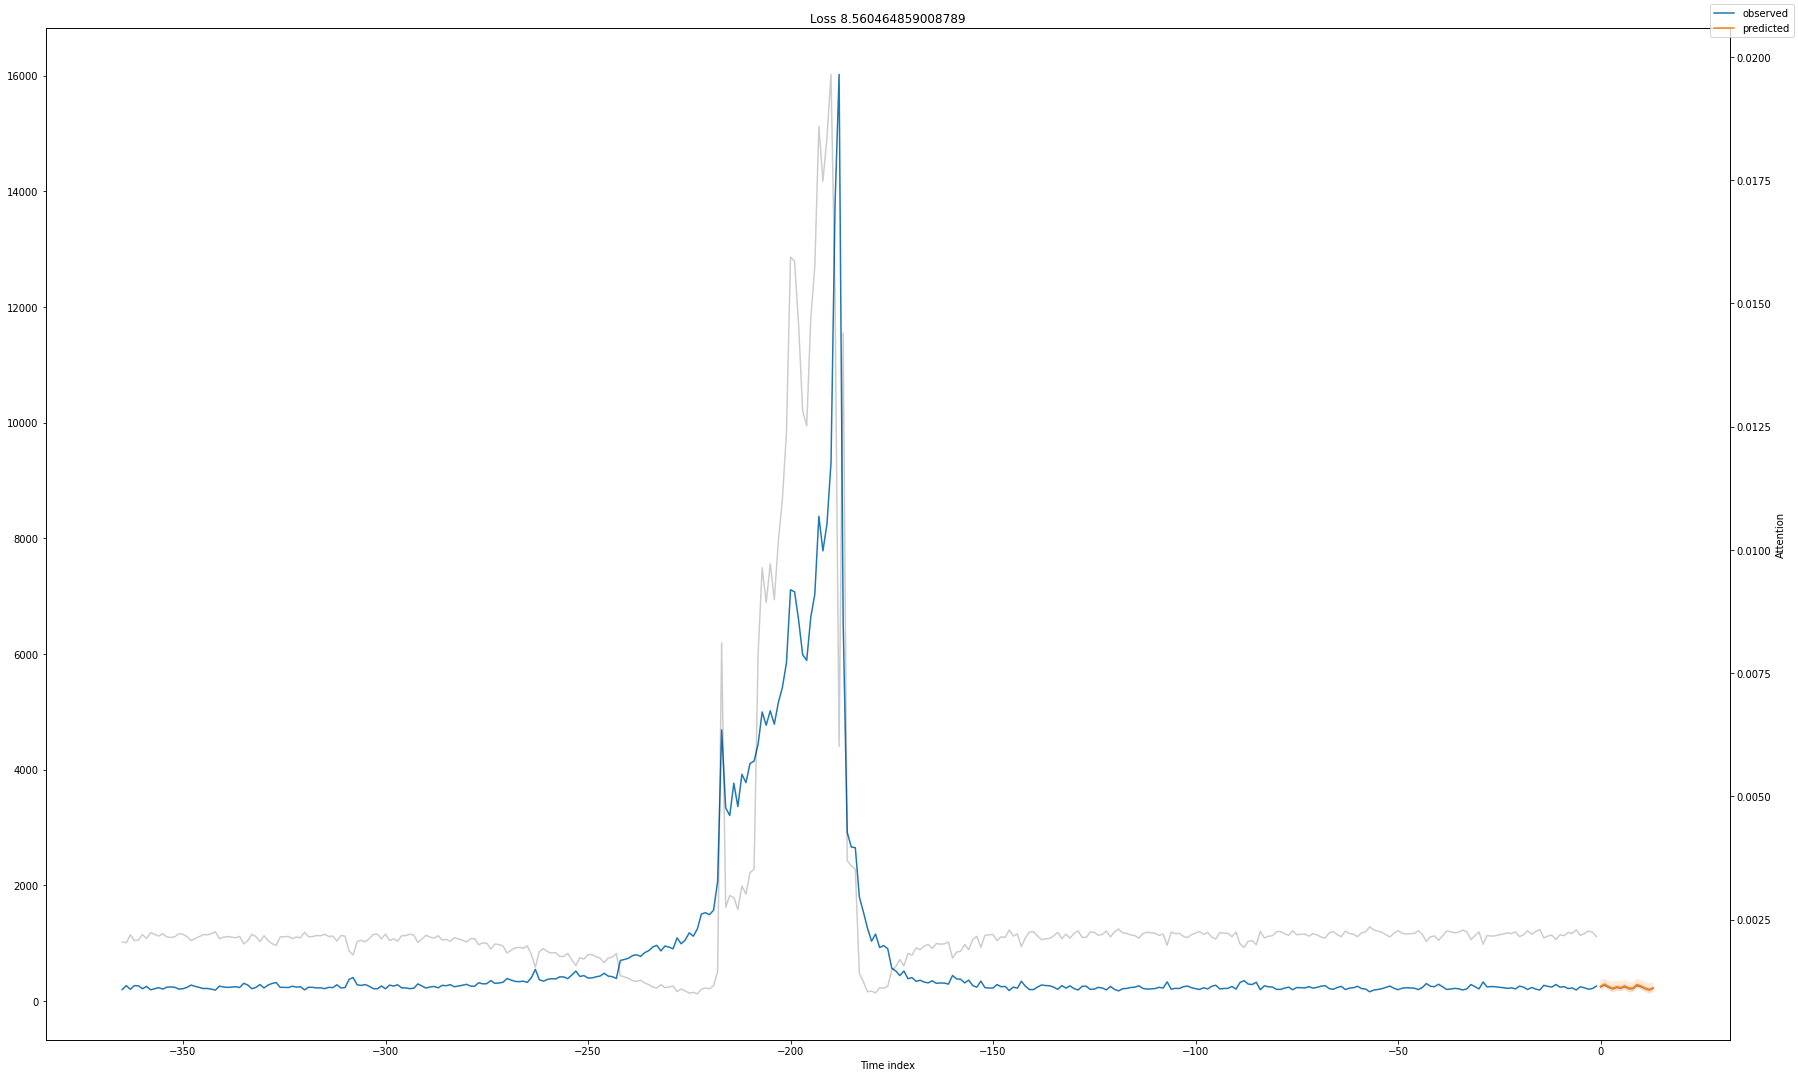

In [19]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x["article"] == "All_I_Want_for_Christmas_Is_You")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0,add_loss_to_title=True)